# Recurrent Neural Networks

| Cristóbal Eyzaguirre |  | ceyzaguirre4@uc.cl |  | https://ceyzaguirre4.github.io |
| :---: | :---: | :---: | :---: | :---: |

# Import Base Dependencies

In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
try:
    from tqdm.notebook import tqdm, trange
except:
    from tqdm import tqdm, trange

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext import data, datasets, vocab

In [3]:
# for reproducibility
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'using {DEVICE}')

using cuda


# General Utilities

In [5]:
def num_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# RNN Base

![](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png)

from colah.github.io

<br>

___

<br>

**Elman RNN Cell** (vainilla RNN cell)

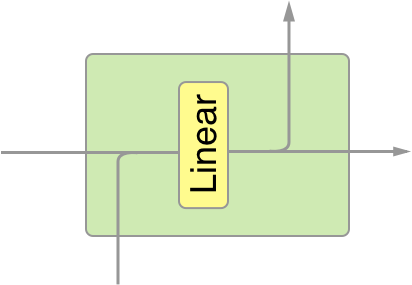

In [6]:
class RNNCell(nn.Module):
    """
    Implementation of Elman RNN cell (vainilla RNN cell).
    """
    def __init__(self, input_size, hidden_size):
        super().__init__()

        # model hyperparameters
        self.hidden_size = hidden_size

        # model layers (input to hidden)
        self.x2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)

    # RNN forward pass
    def forward(self, input, old_hidden):
        """
        input shaped (batch, input_size)
        hidden shaped (batch, hidden_size)
        """
        # run linear layer on combined inputs (batch, hidden_size)
        hidden = torch.tanh(self.x2h(input) + self.h2h(old_hidden))
        
        return hidden

In [7]:
class RNN(nn.Module):
    """
    Implementation of full Elman RNN.
    Executes RNNCell for each of the inputs.
    """
    def __init__(self, input_size, hidden_size):
        super().__init__()

        # model hyperparameters
        self.hidden_size = hidden_size

        self.cell = RNNCell(input_size, hidden_size)
   
    # initialize first hidden state
    def initHidden(self, batch):
        return torch.zeros(batch, self.hidden_size).to(DEVICE)

    # RNN forward pass
    def forward(self, input):
        """
        input shape (batch, seq_len, input_size)

        returns (batch, hidden_size)
        """
        batch, seq_len, *(_) = input.shape

        # initial hidden is vector of zeros (batch, hidden_size)
        hidden = self.initHidden(batch)
        for i in range(seq_len):
            # select ith input from sequence (batch, input_size)
            input_i = input[:,i]

            # run cell on ith input (batch, hidden_size)
            hidden = self.cell(input_i, hidden)
        return hidden

# Sequence to vector

---

### Problem Description: Sentiment Analysis


![](https://formtitanhelpdeskimage.s3.amazonaws.com/70c78f9df2fd5c130e7021644f78f4c5.jpg)

from [formtitan](https://formtitan.com/OptimizationTips/Online-form-with-built-in-Sentiment-Analysis)


## Data


> "We constructed a collection of 50,000 reviews from IMDB, allowing no more than 30 reviews per movie. The constructed dataset contains an even number of positive and negative reviews, so randomly guessing yields 50% accuracy. Following
previous work on polarity classification, we consider
only highly polarized reviews. A negative review
has a score ≤ 4 out of 10, and a positive review has
a score ≥ 7 out of 10."

Maas, A., Daly, R. E., Pham, P. T., Huang, D., Ng, A. Y., & Potts, C. (2011, June). Learning word vectors for sentiment analysis. In Proceedings of the 49th annual meeting of the association for computational linguistics: Human language technologies (pp. 142-150).

<br>

---

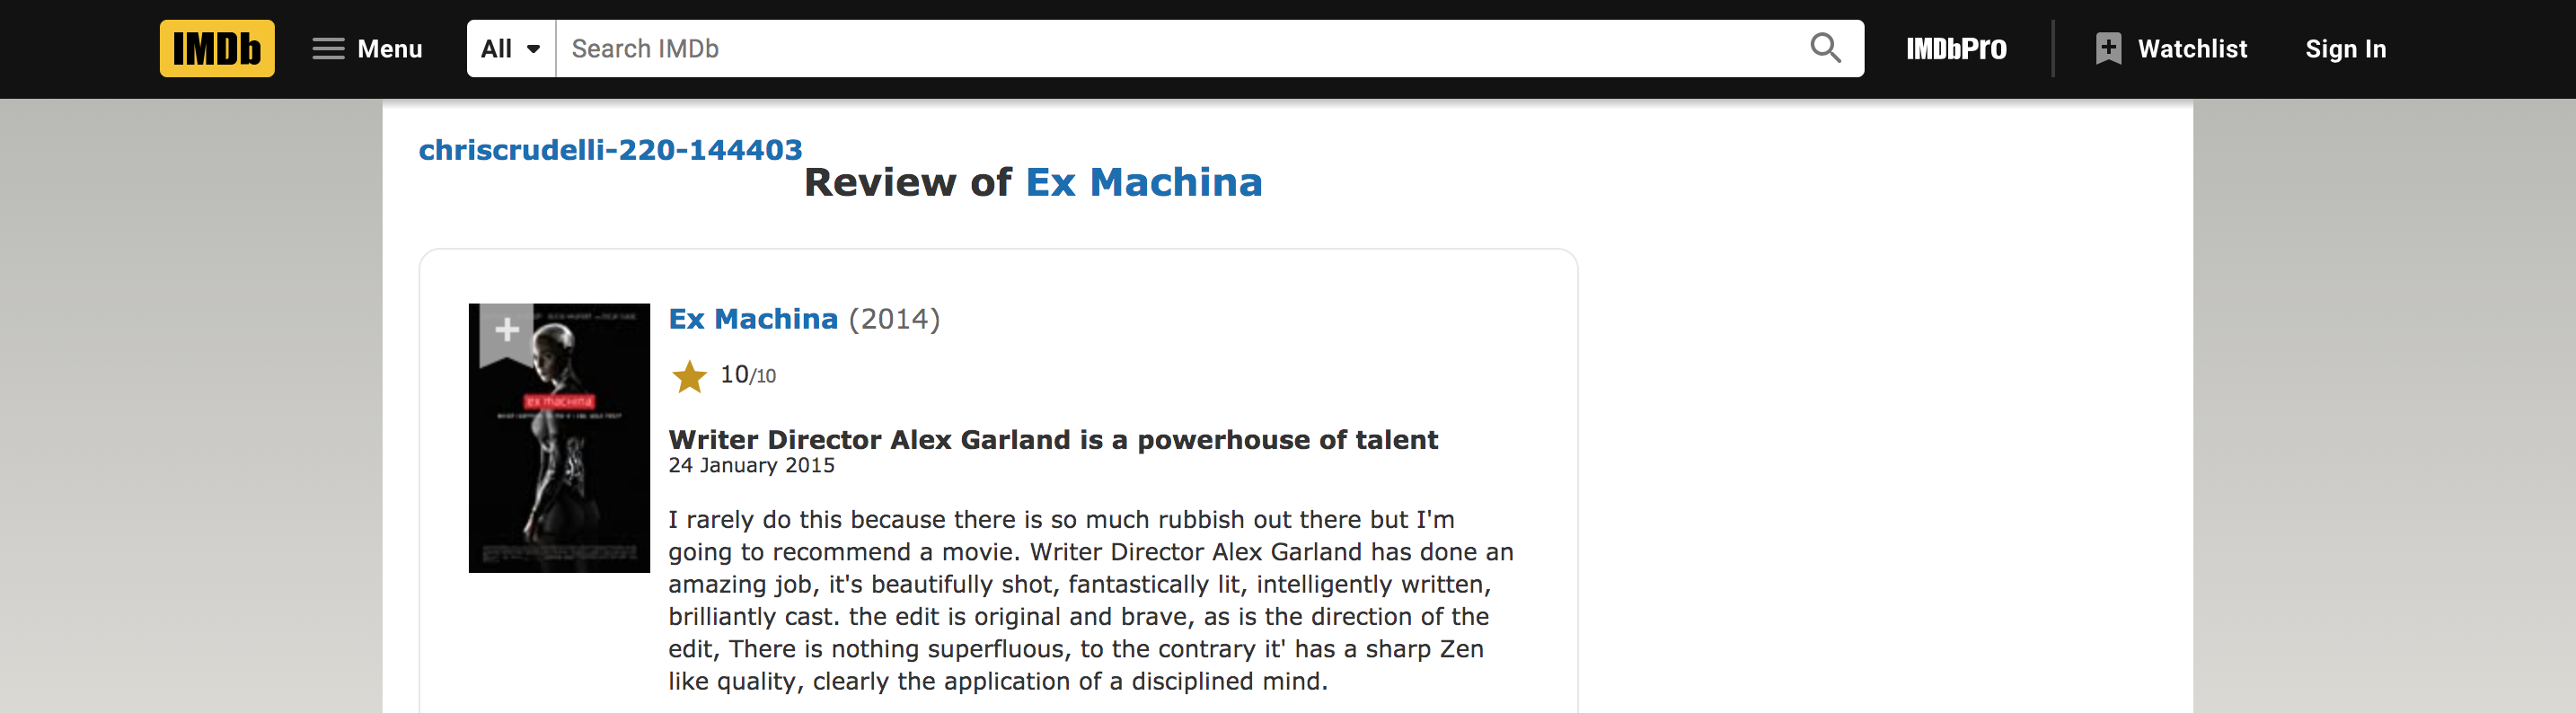

screeshot imbd.com

### Loading data

In [8]:
# set up fields
TEXT = data.Field(lower=True, batch_first=True,
                  tokenize='spacy',
                  fix_length=250, pad_first=False)
LABEL = data.Field(sequential=False)

# load both splits of data
train, test = datasets.IMDB.splits(TEXT, LABEL)

aclImdb_v1.tar.gz:   0%|          | 0.00/84.1M [00:00<?, ?B/s]

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:03<00:00, 21.9MB/s]


In [9]:
# print sample
' '.join(train[0].text)

"people call this a comedy , but when i just watched it , i laughed < br /><br />only once . i guess the problem is that i first saw it when i was 14,<br /><br />and i was n't old enough to understand that it was n't meant to be < br /><br />taken seriously . there were quite a few scenes that were meant < br /><br />to be funny , but i cared too much about the characters to laugh at < br /><br />them.<br /><br />i suggest that you watch this film next time you 're falling in love,<br /><br />and try to take it seriously . i think you 'll find that , despite a few silly < br /><br />flaws , it 's one of the most moving love stories you 've ever seen ."

#### Problem: un-normalized lengths

We want to batch several sentences...


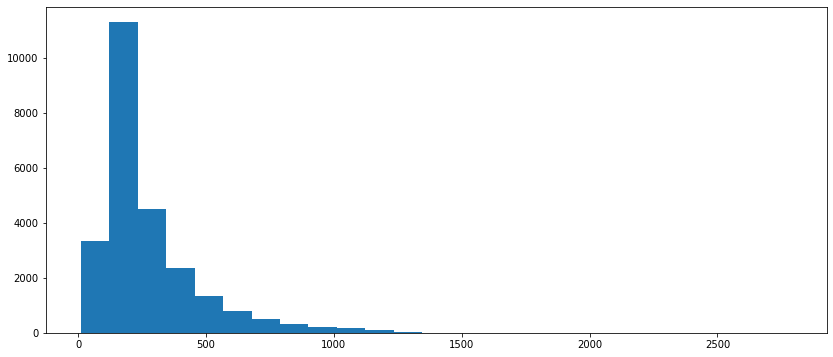

In [10]:
# length distributions of train data
plt.figure(figsize=(14, 6))
plt.hist([len(x.text) for x in train], bins=25)
plt.show()

#### Solution:

Fix length of sentences.

- If length is longer that:
    -  strip remainder
- Else:
    - pad with special "word" (\<PAD\>)

![](https://juditacs.github.io/assets/padded_sequence.png)

from [here](http://juditacs.github.io/2018/12/27/masked-attention.html)

In [11]:
# build the vocabulary
TEXT.build_vocab(train,
                 max_size=25000,
                 vectors=vocab.GloVe(name='6B', dim=200))
LABEL.build_vocab(train)

train_iter, test_iter = data.BucketIterator.splits((train, test),
                                                   batch_size=64,
                                                   device=DEVICE)

.vector_cache/glove.6B.zip: 862MB [06:28, 2.22MB/s]                           
100%|█████████▉| 398808/400000 [00:29<00:00, 13470.99it/s]

In [12]:
# print one example of train sentence to show "pad"
batch = next(iter(train_iter))
print(batch.text[0])

100%|█████████▉| 398808/400000 [00:40<00:00, 13470.99it/s]

tensor([ 5170,     2,  1665,  1682,    19,    37,     7,    72,   520,  6551,
          292,     7,   130, 13795,    12,   354,     8,   122,   160,     8,
          160,   687,  2928,    65,    12,   197,   361,    45,   401,     4,
           47,   244,    12,   118,    12,   158,   306,   189,   409,    39,
          236,   302,     5,     2,   238,   219,   481,    49,   722,   233,
            4,  5943,  1810,  4256,   310,     2,   419,  1665,   254,   161,
         1682,    22,  1253,  2338,  5129,    14,    81,    71,    38,  2195,
            8,     4,    62,    16,   179,     3,  1378,     3, 23466,     3,
         1957,     3,     5,     6,   188,    63,     4, 10139, 23622,     5,
         8987, 10869,   217,  1179,     2,   187,    64,    85,    20,  5170,
           16, 10123,     4, 11328,     3,     2,  1094,  1615,     3,     5,
        16198,     2,   923,     3,  5081,    37,   107,     6,   419,  3015,
           11,  5170,    16,   130,     4,   167,    12,   223, 

## **Concept introduction:** word embeddings

We use Embedding Tables to map words to learnt vectors in space.

In particular, we can load vectors from another model ([word2vec](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf), [GloVe](https://www.aclweb.org/anthology/D14-1162.pdf)) to help convergence.

![](https://www.researchgate.net/profile/Tom_Kenter/publication/325451970/figure/fig1/AS:632023664304129@1527697592901/Visualization-of-3-dimensional-word-embeddings.png)

Kenter, Tom. (2017). Text Understanding for Computers.

<br>

---

<br>

**Embedding implementation**

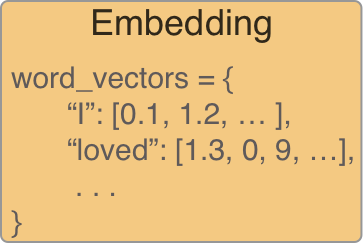



## Train Utils

In [13]:
def train_one_epoch(model, dataloader, optimizer, history):
    """
    Performs a single epoch loop in which the optimizer is used to update
    the weights of the model to better approximate the true distribution 
    of the datapoints and associated labels in the dataloader.
    """
    model.train()
    for batch in dataloader:
        # forward pass
        y_pred = model(batch.text).view(-1)
        y_gt = (batch.label - 1).float()
 
        # compute loss for backward pass
        loss = F.binary_cross_entropy_with_logits(y_pred, y_gt)

        history['train_loss'].append(loss.item())

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [14]:
def eval_one_epoch(model, dataloader, optimizer, history):
    """
    Performs a single evaluation loop in which the performance of 
    the model is meassured against the datapoints in the dataloader.
    """
    model.eval()
    history['eval_acc'].append(0)
    history['eval_loss'].append(0)
    with torch.no_grad():
        for batch in dataloader:
            # forward pass
            y_pred = torch.sigmoid(model(batch.text)).view(-1)
            y_gt = (batch.label - 1).float()
            
            # compute loss and accuracy for later plotting.
            loss = F.binary_cross_entropy(y_pred, y_gt).mean()
            accuracy = (y_pred.round() == y_gt).float().mean()

            history['eval_acc'][-1] += (accuracy / len(dataloader)).item()
            history['eval_loss'][-1] += (loss / len(dataloader)).item()

In [15]:
def train_model(model, train_dataloader, test_dataloader, optimizer, epochs):
    """
    Train and evaluate the model `epochs` times.
    """
    history = defaultdict(list)     # to track loss and accuracy progress.
    for epoch in trange(epochs):
        train_one_epoch(model, train_dataloader, optimizer, history)
        eval_one_epoch(model, test_dataloader, optimizer, history)
    return history

## Full Model \#1: RNN

The full model for sentiment analysis takes a sequence of words from the review as input.

- Each word is mapped to its corresponding vector in the embedding table.
- An RNN aggregates the information of all the words into a single vector.
- The aggregated information is used to predict sentiment.

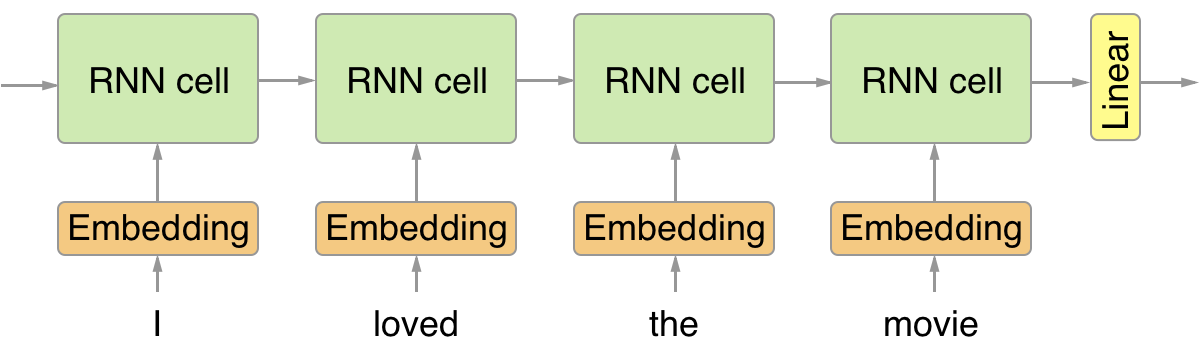

In [16]:
class Seq2Vec(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size):
        super().__init__()

        # model hyperparameters
        self.hidden_size = hidden_size

        self.rnn = RNN(embed_size, hidden_size)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.hidden_2_output = nn.Linear(hidden_size, output_size)

    # forward pass
    def forward(self, input):
        """
        input shape (batch, seq_len)
        """
        # embedd words from input sequence (batch, seq_len, embed_size)
        embedded = self.embedding(input)

        # run RNN (batch, hidden_size)
        last_hidden = self.rnn(embedded)

        # calculate output probs (batch, output_size)
        output = self.hidden_2_output(last_hidden)

        return output

In [17]:
model = Seq2Vec(
    vocab_size=len(TEXT.vocab),
    embed_size=200,
    hidden_size=100,
    output_size=1,
)

In [18]:
num_trainable_parameters(model)

5030701

In [19]:
# OPTIONAL: load pretrained GLOVE weights into embedding
# freezes embedding matrix
word_vecs = TEXT.vocab.vectors
model.embedding.weight.data.copy_(word_vecs)
for param in model.embedding.parameters(): 
    param.requires_grad = False

In [20]:
num_trainable_parameters(model)

30301

In [21]:
# initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [22]:
model = model.to(DEVICE)
history = train_model(model, train_iter, test_iter, optimizer, 20)

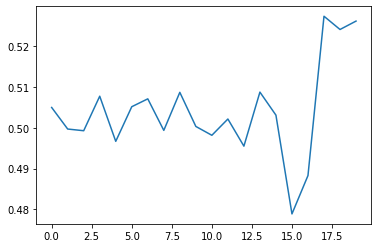

In [23]:
plt.plot(history['eval_acc'])

## Full Model \#2: LSTM

![](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png)

from https://colah.github.io/posts/2015-08-Understanding-LSTMs

In [24]:
class Seq2Vec(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size):
        super().__init__()

        # model hyperparameters
        self.hidden_size = hidden_size

        self.rnn = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.hidden_2_output = nn.Linear(hidden_size, output_size)

    # forward pass
    def forward(self, input):
        """
        input shape (batch, seq_len)
        """
        # embedd input sequences (batch, seq_len, embed_size)
        embedded = self.embedding(input)

        # run LSTM (batch, hidden_size)
        _, (last_hidden, _) = self.rnn(embedded)

        # calculate output probs (batch, output_size)
        output = self.hidden_2_output(last_hidden)

        return output

In [25]:
model = Seq2Vec(
    vocab_size=len(TEXT.vocab),
    embed_size=200,
    hidden_size=100,
    output_size=1,
)

In [26]:
num_trainable_parameters(model)

5121301

In [27]:
# OPTIONAL: load pretrained GLOVE weights into embedding
# freezes embedding matrix
word_vecs = TEXT.vocab.vectors
model.embedding.weight.data.copy_(word_vecs)
for param in model.embedding.parameters(): 
    param.requires_grad = False

In [28]:
num_trainable_parameters(model)

120901

In [29]:
# initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [30]:
model = model.to(DEVICE)
history = train_model(model, train_iter, test_iter, optimizer, 20)

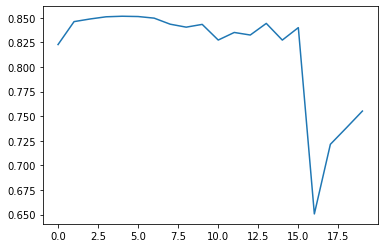

In [31]:
plt.plot(history['eval_acc'])

## Full Model \#3: BiLSTM

![](https://miro.medium.com/max/764/1*6QnPUSv_t9BY9Fv8_aLb-Q.png)

from [here](https://towardsdatascience.com/understanding-bidirectional-rnn-in-pytorch-5bd25a5dd66)

In [32]:
class Seq2Vec(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size):
        super().__init__()

        # model hyperparameters
        self.hidden_size = hidden_size

        self.rnn = nn.LSTM(embed_size, hidden_size, batch_first=True, bidirectional=True)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.hidden_2_output = nn.Linear(2*hidden_size, output_size)

    # forward pass
    def forward(self, input):
        """
        input shape (batch, seq_len)
        """  
        # embedd input sequences (batch, seq_len, embed_size)
        embedded = self.embedding(input)

        # run RNN (2, batch, hidden_size)
        _, (last_hidden, _) = self.rnn(embedded)

        # reshape (batch, 2*hidden_size)
        last_hidden = last_hidden\
            .permute(1, 0, 2)\
            .reshape(-1, 2*self.hidden_size)

        # calculate output probs (batch, output_size)
        output = self.hidden_2_output(last_hidden)

        return output

In [33]:
model = Seq2Vec(
    vocab_size=len(TEXT.vocab),
    embed_size=200,
    hidden_size=100,
    output_size=1,
)

In [34]:
num_trainable_parameters(model)

5242201

In [35]:
# OPTIONAL: load pretrained GLOVE weights into embedding
# freezes embedding matrix
word_vecs = TEXT.vocab.vectors
model.embedding.weight.data.copy_(word_vecs)
for param in model.embedding.parameters(): 
    param.requires_grad = False

In [36]:
num_trainable_parameters(model)

241801

In [37]:
# initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [38]:
model = model.to(DEVICE)
history = train_model(model, train_iter, test_iter, optimizer, 20)

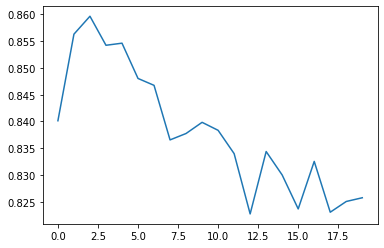

In [39]:
plt.plot(history['eval_acc'])

# Tarea

Agregar otra capa lineal a modelo de LSTM (no bidireccional) como se muestra en la figura.

Pruebe variantes de 50, 150 y 300 neuronas en la capa oculta.

- Graficar precisión para las 3 y comente. 
- Calcular parámetros de los 3 modelos y comente.

*(Consejo: debe tener dos capas `linear`)*

| A la izquierda se muestra diagrama actual de salida de la red. Implementar el de la izquierda agregando otra capa. |
| :--: |
| 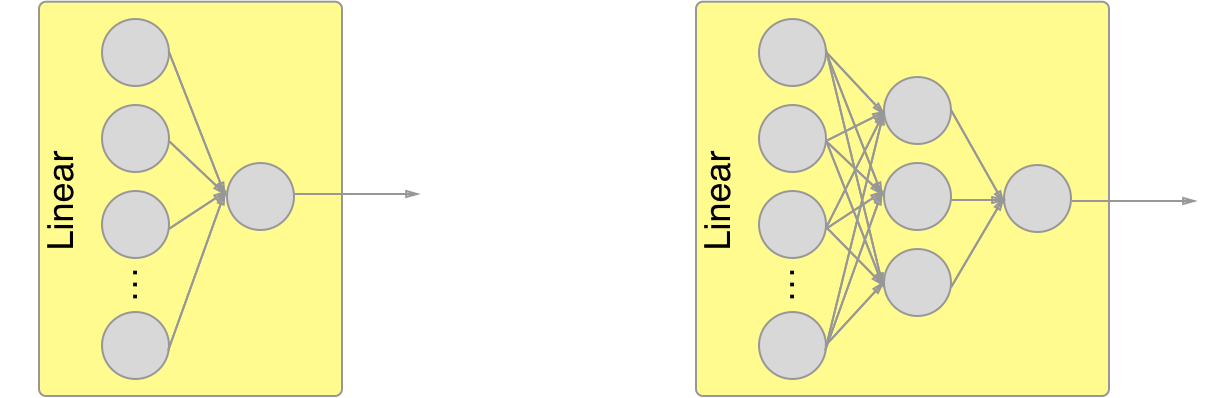 |



In [40]:
class Seq2Vec(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size):
        super().__init__()

        # model hyperparameters
        self.hidden_size = hidden_size

        self.rnn = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.embedding = nn.Embedding(vocab_size, embed_size)

        # TODO
        self.hidden_2_inter = ...
        self.inter_2_output = ...

    # forward pass
    def forward(self, input):
        """
        input shape (batch, seq_len)
        """
        # embedd input sequences (batch, seq_len, embed_size)
        embedded = self.embedding(input)

        # run LSTM (batch, hidden_size)
        _, (last_hidden, _) = self.rnn(embedded)

        # TODO
        vector_intermedio = ...
        output = ...

        return output

In [41]:
model = Seq2Vec(
    vocab_size=len(TEXT.vocab),
    embed_size=200,
    hidden_size=100,
    output_size=1,
)

In [ ]:
num_trainable_parameters(model)

In [43]:
# OPTIONAL: load pretrained GLOVE weights into embedding
# freezes embedding matrix
word_vecs = TEXT.vocab.vectors
model.embedding.weight.data.copy_(word_vecs)
for param in model.embedding.parameters(): 
    param.requires_grad = False

In [ ]:
num_trainable_parameters(model)

In [45]:
# initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
model = model.to(DEVICE)
history = train_model(model, train_iter, test_iter, optimizer, 20)

In [ ]:
plt.plot(history['eval_acc'])